In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from glob import glob
import config
import utils
from os.path import join as j
import numpy as np
import json

# Classification

In [4]:
CLASSIFIERS = {str(c) for c in config.HPARAMS.keys()}
print(CLASSIFIERS)

DETERMINISTIC = {str(c) for c in config.DETERMINISTIC}
print(DETERMINISTIC)

NUM_CLASSES = {2, 3}

CRYPTO = {str(c) for c in config.Cryptocurrency}
print(CRYPTO)

{'GNB', 'MNB', 'RFC', 'SVC', 'MLP', 'LG', 'KNN'}
{'GNB', 'MNB', 'KNN'}
{'LTC', 'ETH', 'BTC'}


In [5]:
RESULTS_DIR = "out_50_2"

CLASS_RESULTS = j(RESULTS_DIR, "metrics")
TRADING_RESULTS = j(RESULTS_DIR, "trading")

In [6]:
def process_classification_results(data, num_classes):
    d = {
        "F1_macro": data.loc["f1-score", "macro avg"],
        "F1_weighted": data.loc["f1-score", "weighted avg"],
        "Accuracy": data.loc["precision", "accuracy"],
    }
    
    if num_classes == 2:
        d["F1_O"] = data.loc["f1-score", "1"]
        d["Precision_O"] = data.loc["precision", "1"]
        d["Recall_O"] = data.loc["recall", "1"]
    else:
        d["F1_O"] = data.loc["f1-score", ["-1", "1"]].mean()
        d["Precision_O"] = data.loc["precision", ["-1", "1"]].mean()
        d["Recall_O"] = data.loc["recall", ["-1", "1"]].mean()
    
    return d

In [8]:
results = list()

# read and process deterministic models
for model in list(DETERMINISTIC) + ["HE"]:
    for n_class in NUM_CLASSES:
        for crypto in CRYPTO:
            filename = utils.get_filename(crypto, model, n_class, None)
            res = pd.read_csv(j(CLASS_RESULTS, filename), index_col="metric")
            d = process_classification_results(res, n_class)
            d["classifier"] = model
            d["n_class"] = n_class
            d["crypto"] = crypto
            results.append(d)
            
deterministic = pd.DataFrame(results)

results = list()

# read and process non-deterministic models: average across seeds (random initializations)
for model in list(CLASSIFIERS - DETERMINISTIC) + ["LSTM"]:
    for n_class in NUM_CLASSES:
        for crypto in CRYPTO:
            for seed in range(10):
                filename = utils.get_filename(crypto, model, n_class, seed)
                
                if model == "LSTM":
                    res = pd.read_csv(j(CLASS_RESULTS, filename), index_col=0)
                    res.index.name = "metric"
                else:
                    res = pd.read_csv(j(CLASS_RESULTS, filename), index_col="metric")
                
                d = process_classification_results(res, n_class)
                d["classifier"] = model
                d["n_class"] = n_class
                d["crypto"] = crypto
                d["seed"] = seed
                results.append(d)
                
non_deterministic_mean = pd.DataFrame(results).groupby(["classifier", "n_class", "crypto"]).mean().drop("seed", axis=1).reset_index()
non_deterministic_std = pd.DataFrame(results).groupby(["classifier", "n_class", "crypto"]).std().drop("seed", axis=1).reset_index()

In [9]:
deterministic.pivot_table(
    index="classifier", columns=["n_class", "crypto"]
).drop(
    "Accuracy", axis=1
).to_csv(j(RESULTS_DIR, "comparison_det.csv"))

In [10]:
non_deterministic_mean.pivot_table(
    index="classifier", columns=["n_class", "crypto"]
).drop(
    "Accuracy", axis=1
).to_csv(j(RESULTS_DIR, "comparison_nondet_mean.csv"))

non_deterministic_std.pivot_table(
    index="classifier", columns=["n_class", "crypto"]
).drop(
    "Accuracy", axis=1
).to_csv(j(RESULTS_DIR, "comparison_nondet_std.csv"))

# Trading

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
sns.set_theme("notebook", style="white", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [13]:
EQUITIES_FOLDER = j(RESULTS_DIR, "portfolio_simulations_equity_trend")

### Equities with three classes

In [14]:
n_class = 3

equities = list()
for classifier in list(CLASSIFIERS - DETERMINISTIC) + ["LSTM"]:
    for seed in range(10):
        filename = utils.get_equity_filename(classifier, n_class, seed)
        df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
        df["seed"] = seed
        df["classifier"] = classifier
        equities.append(df)
        
for classifier in list(DETERMINISTIC) + ["HE"]:
    filename = utils.get_equity_filename(classifier, n_class, None)
    df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
    df["classifier"] = classifier
    equities.append(df)
        
equities = pd.concat(equities, axis=0)

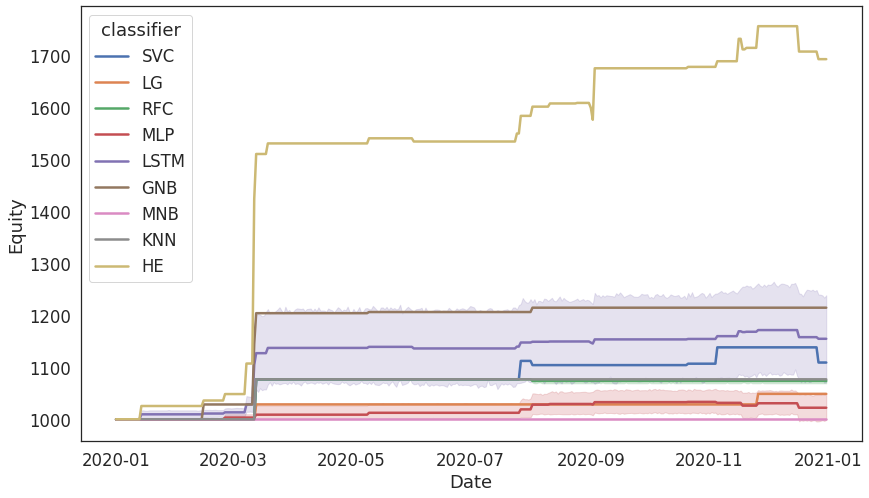

In [15]:
plt.figure(figsize=(14,8))
sns.lineplot(data=equities, x="Date", y="Equity", hue="classifier")
plt.savefig(j(RESULTS_DIR, "chart_equity_3_classes.pdf"))

### Equities with 2 classes (Overreaction/Non overreaction)

In [16]:
n_class = 2

equities = list()
for classifier in list(CLASSIFIERS - DETERMINISTIC) + ["LSTM"]:
    for seed in range(10):
        filename = utils.get_equity_filename(classifier, n_class, seed)
        df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
        df["seed"] = seed
        df["classifier"] = classifier
        equities.append(df)
        
for classifier in list(DETERMINISTIC) + ["HE"]:
    filename = utils.get_equity_filename(classifier, n_class, None)
    df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
    df["classifier"] = classifier
    equities.append(df)
        
equities = pd.concat(equities, axis=0)

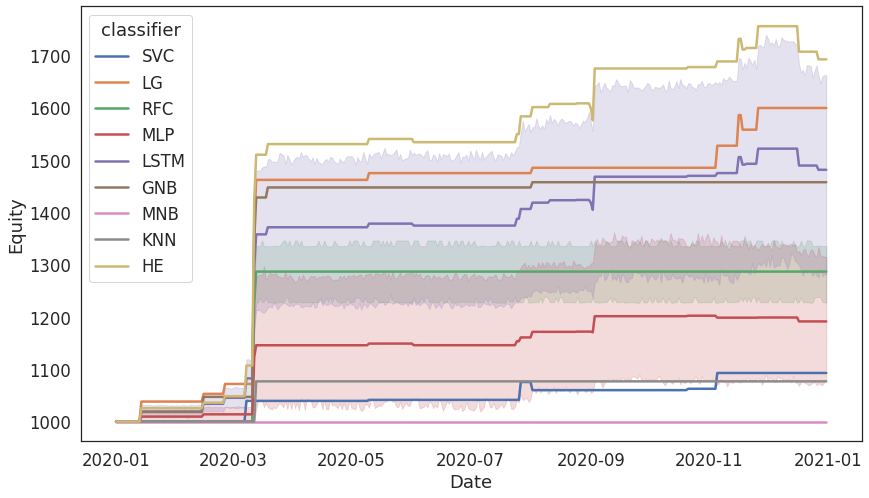

In [17]:
plt.figure(figsize=(14,8))
sns.lineplot(data=equities, x="Date", y="Equity", hue="classifier")
plt.savefig(j(RESULTS_DIR, "chart_equity_2_classes.pdf"))

## Trading tables

In [18]:
results = list()
for classifier in list(DETERMINISTIC) + ["HE"]:
    for n_class in NUM_CLASSES:
        filename = utils.get_trading_stats_filename(classifier, n_class, None)
        with open(j(RESULTS_DIR, "trading", filename)) as fp:
            d = json.load(fp)
            d["classifier"] = classifier
            d["n_class"] = n_class
            results.append(d)
            

non_det_res = list()

for classifier in list(CLASSIFIERS - DETERMINISTIC) + ["LSTM"]:
    for n_class in NUM_CLASSES:        
        for seed in range(10):
            filename = utils.get_trading_stats_filename(classifier, n_class, seed)
            with open(j(RESULTS_DIR, "trading", filename)) as fp:
                d = json.load(fp)
                d["classifier"] = classifier
                d["n_class"] = n_class
                non_det_res.append(d)
            

non_deterministic_mean = pd.DataFrame(non_det_res).groupby(["classifier", "n_class"]).mean().reset_index()
non_deterministic_std = pd.DataFrame(non_det_res).groupby(["classifier", "n_class"]).std().reset_index()
            
results_det = pd.DataFrame(results)

final = pd.concat([results_det, non_deterministic_mean], axis=0).set_index("classifier").sort_values("n_class")
final.to_csv(j(RESULTS_DIR, "comparison_trading_stats.csv"))
non_deterministic_std.set_index("classifier").sort_values("n_class").to_csv(j(RESULTS_DIR, "comparison_trading_stats_nondet_std.csv"))

final

,long_pos,short_pos,total_pos,success_pos,success_perc,long_return,long_return_mean,long_return_std,short_return,short_return_mean,short_return_std,total_return,days,avg allocations,n_class
classifier,,,,,,,,,,,,,,,
GNB,5.0,6.0,11.0,10.0,90.909091,0.265548,0.053110,0.028339,0.929099,0.154850,0.153294,1.194647,348.0,0.238506,2
RFC,0.5,1.7,2.2,2.2,100.000000,0.052267,0.052267,0.000000,0.414031,0.229846,0.077641,0.466298,348.0,0.050862,2
MLP,1.8,2.5,4.3,3.3,64.833333,0.042383,0.013598,0.008450,0.159876,0.048222,0.051721,0.202259,348.0,0.157471,2
LSTM,9.7,15.1,24.8,18.4,71.092595,0.254023,0.022829,0.025206,0.742459,0.068255,0.052628,0.996481,348.0,1.532759,2
SVC,3.0,3.0,6.0,5.0,83.333333,0.111496,0.037165,0.025937,0.041823,0.013941,0.022565,0.153319,348.0,0.209770,2
HE,18.0,29.0,47.0,35.0,74.468085,0.463647,0.025758,0.039451,1.473815,0.050821,0.092480,1.937462,348.0,3.000000,2
LG,7.0,12.0,19.0,16.0,84.210526,0.398403,0.056915,0.027141,1.021795,0.085150,0.130808,1.420198,348.0,0.626437,2
KNN,2.0,0.0,2.0,2.0,100.000000,0.163468,0.081734,0.022801,0.000000,0.000000,0.000000,0.163468,348.0,0.028736,2
MNB,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,348.0,0.000000,2


### Create zip folder

In [19]:
import shutil

shutil.make_archive(RESULTS_DIR, 'zip', RESULTS_DIR)

'/home/dauin_user/gattanasio/CTS/out_50_2.zip'